I can do all this through him who givs me strength

# Kaggle : New York City Taxi Trip Duration
### Share code and data to improve ride time predictions

https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels

# EDA (Exploratory Data Analysis)

In [1]:
from IPython.display import display
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Map
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster   
from geographiclib.geodesic import Geodesic

#distance
from math import sin, cos, sqrt, atan2, radians
import haversine

# time/day data
import time, datetime                        
from collections import namedtuple
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Regression
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.cross_validation import cross_val_score
# Decission Tree regressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

/home/jk/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1 Understanding Data Set

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## 1.3 Datetime 다루기

datetime은 pd.to_datetime method(?)를 사용해야 datetime에서 년, 월, 일 Data를 활용할 수 있다

In [3]:
# Pickup/Dropoff_Datetime Datatype 변경

train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [4]:
#day of week
#date by month
train["pick_month"] = train["pickup_datetime"].dt.month.astype("int")
test["pick_month"] = test["pickup_datetime"].dt.month.astype("int")

#Monday=0, Sunday=6
train["pick_week"] = train["pickup_datetime"].dt.dayofweek.astype("int")
test["pick_week"] = test["pickup_datetime"].dt.dayofweek.astype("int")

#date
train['pick_date'] = train['pickup_datetime'].dt.date
test['pick_date'] = test['pickup_datetime'].dt.date

#date by hour
train["pick_hour"] = train["pickup_datetime"].dt.hour.astype("int")
test["pick_hour"] = test["pickup_datetime"].dt.hour.astype("int")

## 1.4 Time division

In [5]:
bins = [0, 8, 18, 24]
group_names = ["before work", "work", "after work"]
train['work_hour'] = pd.cut(train['pick_hour'], bins, labels=group_names, right=False)

test['work_hour'] = pd.cut(test['pick_hour'], bins, labels=group_names, right=False)

## 1.5 Holiday

In [6]:
# Load a list of holidays in the US
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

# Load business days
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.DatetimeIndex(start = train.pickup_datetime.min(), 
                                 end = train.pickup_datetime.max(), 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date
# Fot test
business_days = pd.DatetimeIndex(start = test.pickup_datetime.min(), 
                                 end = test.pickup_datetime.max(), 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date

In [7]:
# Create features relating to time
train['pickup_holiday'] = pd.to_datetime(train.pickup_datetime.dt.date).isin(holidays)
train['pickup_holiday'] = train.pickup_holiday.map(lambda x: 1 if x == True else 0)

train['pickup_businessday'] = pd.to_datetime(train.pickup_datetime.dt.date).isin(business_days)
train['pickup_businessday'] = train.pickup_businessday.map(lambda x: 1 if x == True else 0)


test['pickup_holiday'] = pd.to_datetime(test.pickup_datetime.dt.date).isin(holidays)
test['pickup_holiday'] = test.pickup_holiday.map(lambda x: 1 if x == True else 0)

test['pickup_businessday'] = pd.to_datetime(test.pickup_datetime.dt.date).isin(business_days)
test['pickup_businessday'] = test.pickup_businessday.map(lambda x: 1 if x == True else 0)


In [8]:
# Dont' need this feature any more
train = train.drop('pickup_datetime', 1)
test = test.drop('pickup_datetime', 1)

## 2.1 Distance

### 2.1.1 Haversine Distance

In [9]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

In [10]:
train['haversine_distance'] = train.apply(lambda r: haversine.haversine((r['pickup_latitude'],r['pickup_longitude']),
                                                                  (r['dropoff_latitude'], r['dropoff_longitude'])), axis=1)

test['haversine_distance'] = test.apply(lambda r: haversine.haversine((r['pickup_latitude'],r['pickup_longitude']),
                                                                  (r['dropoff_latitude'], r['dropoff_longitude'])), axis=1)

In [11]:
# R = 6371.0

# dist = []

# for i in range(len(df)):
#     lat1 = radians(taxi1.iloc[i,6])
#     lon1 = radians(taxi1.iloc[i,5])
#     lat2 = radians(taxi1.iloc[i,8])
#     lon2 = radians(taxi1.iloc[i,7])

#     dlon = lon2 - lon1
#     dlat = lat2 - lat1

#     a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))

#     distance = R * c
#     dist.append(distance)
    
# df['distance'] = dist

### 2.1.2 Manhattan Distance

In [12]:
train['manhattan_distance'] = (abs(train.dropoff_longitude - train.pickup_longitude) +
                            abs(train.dropoff_latitude - train.pickup_latitude))

In [13]:
test['manhattan_distance'] = (abs(test.dropoff_longitude - test.pickup_longitude) +
                            abs(test.dropoff_latitude - test.pickup_latitude))

## 2.2 Direction

In [14]:
def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [15]:
train['bearing'] = calculate_bearing(train.pickup_latitude,
                                     train.pickup_longitude,
                                     train.dropoff_latitude,
                                     train.dropoff_longitude)

In [16]:
test['bearing'] = calculate_bearing(test.pickup_latitude,
                                     test.pickup_longitude,
                                     test.dropoff_latitude,
                                     test.dropoff_longitude)

# 3. Data Cleaning

## 3.1 Removing Outliner based on rational

In [17]:
train.loc[train.haversine_distance > 200] = np.nan ##200km 넘는 데이터 제거
train.loc[train.trip_duration > 40000] = np.nan ##40000초(약 11시간)가 넘는 데이터 제거
train.loc[train.passenger_count == 0] = np.NAN   ### passenger 수가 0인 데이터 제거
train.dropna(inplace=True)

In [18]:
print(train.shape)
print(test.shape)

(1456576, 20)
(625134, 18)


In [19]:
train['log_duration'] = np.log1p(train['trip_duration'])
train.loc[:, 'log_duration'].tail()

1458639    6.658011
1458640    6.486161
1458641    6.639876
1458642    5.924256
1458643    5.293305
Name: log_duration, dtype: float64

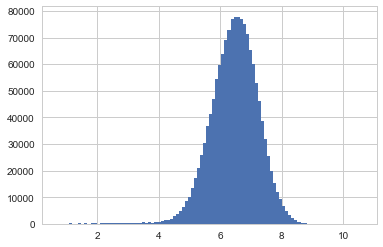

In [20]:
plt.hist(train['log_duration'].values, bins=100)
plt.show()

# 4. Data Mining

# 4.1 Speed

### 4.1.1 Average Speed

In [21]:
train.loc[:, 'avg_speed_h'] = 1000 * train['haversine_distance'] / train['trip_duration']

### 4.1.2 Average Speed for regions

In [ ]:
# train["p_lon"] = np.round(train['pickup_longitude'], 2)
# train["p_lat"] = np.round(train['pickup_latitude'], 2)
# train["d_lon"] = np.round(train['dropoff_longitude'], 2)
# train["d_lat"] = np.round(train['dropoff_latitude'], 2)

In [ ]:
# train_p = train[['avg_speed_h', 'p_lon', 'p_lat']].groupby(['p_lon', 'p_lat']).mean().reset_index()
# train_p = train.rename(columns = {'avg_speed_h': 'ave_speed_p'})
# train_d = train[['avg_speed_h', 'd_lon', 'd_lat']].groupby(['d_lon', 'd_lat']).mean().reset_index()
# train_d = train_d.rename(columns = {'avg_speed_h': 'ave_speed_d'})

In [ ]:
# train = pd.merge(train_p, train_d, on = ['d_lon', 'd_lat'], how = 'left')

In [ ]:
# train.head()

In [ ]:
# test["p_lon"] = np.round(test['pickup_longitude'], 2)
# test["p_lat"] = np.round(test['pickup_latitude'], 2)
# test["d_lon"] = np.round(test['dropoff_longitude'], 2)
# test["d_lat"] = np.round(test['dropoff_latitude'], 2)

In [ ]:
# print(train_p.isnull().sum())

## 4.2 K-means Clustering

### 4.2.1 Coordinate of lat, long

In [ ]:
# coords = np.vstack((taxi1[['pickup_latitude', 'pickup_longitude']].values,
#                     taxi1[['dropoff_latitude', 'dropoff_longitude']].values))

In [ ]:
# sample_ind = np.random.permutation(len(coords))[:500000]
# kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
# taxi1.loc[:, 'pickup_cluster'] = kmeans.predict(taxi1[['pickup_latitude', 'pickup_longitude']])
# taxi1.loc[:, 'dropoff_cluster'] = kmeans.predict(taxi1[['dropoff_latitude', 'dropoff_longitude']])

### 4.2.2 Pair of Speed & Distance

## 4.3 Create dummy features

In [22]:
print(train.columns)

Index(['id', 'vendor_id', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pick_month',
       'pick_week', 'pick_date', 'pick_hour', 'work_hour', 'pickup_holiday',
       'pickup_businessday', 'haversine_distance', 'manhattan_distance',
       'bearing', 'log_duration', 'avg_speed_h'],
      dtype='object')


In [23]:
train.head()

,id,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,pick_date,pick_hour,work_hour,pickup_holiday,pickup_businessday,haversine_distance,manhattan_distance,bearing,log_duration,avg_speed_h
0,id2875421,2.0,2016-03-14 17:32:30,1.0,-73.982155,40.767937,-73.964630,40.765602,N,455.0,...,2016-03-14,17.0,work,0.0,1.0,1.498521,0.019859,174.333195,6.122493,3.293452
1,id2377394,1.0,2016-06-12 00:54:38,1.0,-73.980415,40.738564,-73.999481,40.731152,N,663.0,...,2016-06-12,0.0,before work,0.0,0.0,1.805507,0.026478,-178.051506,6.498282,2.723239
2,id3858529,2.0,2016-01-19 12:10:48,1.0,-73.979027,40.763939,-74.005333,40.710087,N,2124.0,...,2016-01-19,11.0,work,0.0,1.0,6.385098,0.080158,-179.629721,7.661527,3.006167
3,id3504673,2.0,2016-04-06 19:39:40,1.0,-74.010040,40.719971,-74.012268,40.706718,N,429.0,...,2016-04-06,19.0,after work,0.0,1.0,1.485498,0.015480,-179.872566,6.063785,3.462700
4,id2181028,2.0,2016-03-26 13:38:10,1.0,-73.973053,40.793209,-73.972923,40.782520,N,435.0,...,2016-03-26,13.0,work,0.0,0.0,1.188588,0.010818,179.990812,6.077642,2.732387


In [24]:
# Create dummy features for these features, then drop these features
dummies = ['work_hour', 'pickup_holiday', 'pickup_businessday',
          'passenger_count', 'vendor_id', 'store_and_fwd_flag']
for feature in dummies:
    dummy_features = pd.get_dummies(train[feature], prefix=feature)
    for dummy in dummy_features:
        train[dummy] = dummy_features[dummy]
    train = train.drop([feature], 1)

In [25]:
train.shape

(1456576, 36)

In [26]:
dfx = train.drop(['id','dropoff_datetime','pick_hour', 'pick_date', 'trip_duration','log_duration'],1)
print(dfx.shape,'\n\n', dfx.columns)

(1456576, 30) 

 Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pick_month', 'pick_week', 'haversine_distance',
       'manhattan_distance', 'bearing', 'avg_speed_h', 'work_hour_before work',
       'work_hour_work', 'work_hour_after work', 'pickup_holiday_0.0',
       'pickup_holiday_1.0', 'pickup_businessday_0.0',
       'pickup_businessday_1.0', 'passenger_count_1.0', 'passenger_count_2.0',
       'passenger_count_3.0', 'passenger_count_4.0', 'passenger_count_5.0',
       'passenger_count_6.0', 'passenger_count_7.0', 'passenger_count_8.0',
       'passenger_count_9.0', 'vendor_id_1.0', 'vendor_id_2.0',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y'],
      dtype='object')


In [27]:
y = train['log_duration']

# Test Set

In [ ]:
dummies = ['work_hour', 'pickup_holiday', 'pickup_businessday',
          'vendor_id', 'store_and_fwd_flag']
for feature in dummies:
    dummy_features = pd.get_dummies(test[feature], prefix=feature)
    for dummy in dummy_features:
        test[dummy] = dummy_features[dummy]
    test = test.drop([feature], 1)

In [ ]:
dfx_test = test.drop(['id', 'pick_hour', 'pick_date'],1)
print(dfx_test.shape,'\n\n', dfx_test.columns)

# 5. Test Regression

In [ ]:
len(dfx)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(dfx, y, test_size=0.20)

In [37]:
model_dt=DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, 
                              min_samples_split=2, min_samples_leaf=1, 
                              min_weight_fraction_leaf=0.0, max_features=None, 
                              random_state=0, max_leaf_nodes=None, presort=False)
model_dt.fit(X_train, y_train)
print(cross_val_score(model_dt,dfx,y,cv=5))

[0.97128694 0.97070696 0.97067991 0.96940014 0.97232061]


In [31]:
importances = model_dt.feature_importances_
indices = np.argsort(importances)[::-1]
# std = np.std([model_dt.feature_importances_ for treet in model_dt.estimators_],
#             axis=0)


# # Print the feature ranking
print("Feature ranking:")

for f in range(dfx.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(dfx.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(dfx.shape[1]), indices)
# plt.xlim([-1, dfx.shape[1]])
# plt.show()

Feature ranking:
1. feature 6 (0.707880)
2. feature 9 (0.269744)
3. feature 27 (0.004703)
4. feature 0 (0.003590)
5. feature 1 (0.003077)
6. feature 3 (0.002965)
7. feature 2 (0.002764)
8. feature 4 (0.001408)
9. feature 5 (0.001208)
10. feature 7 (0.000599)
11. feature 12 (0.000356)
12. feature 11 (0.000306)
13. feature 17 (0.000301)
14. feature 10 (0.000243)
15. feature 18 (0.000172)
16. feature 16 (0.000167)
17. feature 15 (0.000146)
18. feature 19 (0.000132)
19. feature 21 (0.000057)
20. feature 29 (0.000048)
21. feature 20 (0.000040)
22. feature 8 (0.000022)
23. feature 28 (0.000019)
24. feature 13 (0.000018)
25. feature 22 (0.000018)
26. feature 14 (0.000015)
27. feature 23 (0.000002)
28. feature 26 (0.000001)
29. feature 24 (0.000000)
30. feature 25 (0.000000)


In [ ]:
y_test = model_dt.predict(dfx_test)

In [ ]:
y_test = np.exp(y_test) - 1

In [ ]:
y_test = pd.DataFrame(y_test)

In [ ]:
y_test.shpae()

In [ ]:
submission = pd.concat([test['id'], y_test], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission_.csv", index=False)

## Random Forest  (오래걸림)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Random Forest Regressor
model_rnd_frst=RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, 
                                    min_samples_split=2, min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0, max_features='auto', 
                                    max_leaf_nodes=None, min_impurity_decrease=1e-07, 
                                    bootstrap=True, oob_score=False, n_jobs=-1, 
                                    random_state=0, verbose=1, warm_start=False)
model_rnd_frst.fit(X_train, y_train)
print(cross_val_score(model_rnd_frst,dfx,y,cv=5))

In [ ]:
y_test1 = model_rnd_frst.predict(dfx_test)

In [ ]:
y_test1 = np.exp(y_test1) - 1

In [ ]:
y_test1 = pd.DataFrame(y_test1)

In [ ]:
y_test1.shpae()

In [ ]:
submission = pd.concat([test['id'], y_test1], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission_1.csv", index=False)

## Gradient Boosting Regressor

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
model_gb=GradientBoostingRegressor(loss='ls', learning_rate=0.05, n_estimators=400, subsample=1.0,
                                  criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, max_depth=5,
                                  init=None, random_state=None, max_features=None, alpha=0.9, 
                                  verbose=0, 
                                  max_leaf_nodes=None, warm_start=False, presort='auto')
model_gb.fit(X_train, y_train)
print(cross_val_score(model_gb,dfx,y,cv=3))

KeyboardInterrupt: 

In [ ]:
y_test2 = model_rnd_frst.predict(dfx_test)

In [ ]:
y_test2 = np.exp(y_test2) - 1

In [ ]:
y_test2 = pd.DataFrame(y_test2)

In [ ]:
y_test2.shpae()

In [ ]:
submission = pd.concat([test['id'], y_test2], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission_2.csv", index=False)

## KNeighbors Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
model_KNN=KNeighborsRegressor(n_neighbors=5, weights='uniform', 
                                               algorithm='auto', leaf_size=30, p=2, 
                                               metric='minkowski', metric_params=None,
                                               n_jobs=-1)
print(cross_val_score(model_KNN,dfx,y,cv=3))

In [ ]:
y_test3 = model_rnd_frst.predict(dfx_test)

In [ ]:
y_test3 = np.exp(y_test3) - 1

In [ ]:
y_test3 = pd.DataFrame(y_test3)

In [ ]:
y_test3.shpae()

In [ ]:
submission = pd.concat([test['id'], y_test3], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission_3.csv", index=False)

In [ ]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [ ]:
# Partial Regression Plot
fig = sm.graphics.plot_regress_exog(result, "distance")
fig.suptitle("")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,20))
sm.graphics.plot_partregress_grid(result_boston, fig=fig)
fig.suptitle("")
plt.show()

In [ ]:
# 이분산성(heteroskedastic) : 독립변수의 값이 커지면 종속변수의 분산도 커지는 것
plt.scatter(df["x9"], result.resid)
plt.show()

In [ ]:
# Cook's Distance
sm.graphics.plot_leverage_resid2(result)
plt.show()

In [ ]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

In [ ]:
# Fox recommentation 
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(X0, y)
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(X0[idx], y[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()
